**Instructors**: Prof. Keith Chugg (chugg@usc.edu) & Prof. B. Keith Jenkins (jenkins@sipi.usc.edu)

**Notebook**: Written by Prof. Keith Chugg.

# Multiclass Classifier for MNIST (and Fashion MNIST) Using MLP in TensorFlow
In this notebook, we will use TensorFlow to train an ANN/MLP for the MNIST/FMNIST datasets we previously explored with an MSE classifier.

This notebook requires Tensorflow to be installed.  To install this, use `pip install tensorflow` or `conda install tensorflow`.  If you have an Nvidia GPU, you can use `conda install tensorflow-gpu` to have it use the GPU.  If you have an M1/M2 Apple chip, use `pip install tensorflow-macos`

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model



## Accessing the Data
First, let's get a function to get the MNIST or FMNIST data.  Previously, we used PyTorch to access the datasets, but TF also has these built in.  So, we should be familiar with this data.

In [2]:
USE_FASHION_MNIST = True

#### get the daatset

if USE_FASHION_MNIST:
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    tag_name = 'FashionMNIST'
    label_names = ["top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]
else:
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
    tag_name = 'MNIST'
    label_names = [f'{i}' for i in set(test_labels)]

# train_images.shape is (60000, 28, 28)
#test_images.shape (10000, 28, 28)
num_pixels = 28 * 28 
train_images = train_images.reshape( (60000, num_pixels) ).astype(np.float32) / 255.0
test_images = test_images.reshape( (10000, num_pixels) ).astype(np.float32)  / 255.0

## ANN/MLP Model Definition
In TensorFlow, we need to define the model.  Below, we define an ANN that takes a vector of length 784 as input, then has one hidden layer, followed by a SoftMax output layer.

In [3]:
## tSome hyper-parameters for our model
reg_val = 0.001
hidden_nodes = 48


# this uses the Functional API for definning the model
nnet_inputs = Input(shape=(num_pixels,), name='images')
z = Dense(hidden_nodes, activation='relu', kernel_regularizer=regularizers.l2(reg_val), bias_regularizer=regularizers.l2(reg_val), name='hidden')(nnet_inputs)
z = Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(reg_val), bias_regularizer=regularizers.l2(reg_val), name='output')(z)

our_first_model = Model(inputs=nnet_inputs, outputs=z)

#this will print a summary of the model to the screen
our_first_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 images (InputLayer)         [(None, 784)]             0         
                                                                 
 hidden (Dense)              (None, 48)                37680     
                                                                 
 output (Dense)              (None, 10)                490       
                                                                 
Total params: 38,170
Trainable params: 38,170
Non-trainable params: 0
_________________________________________________________________


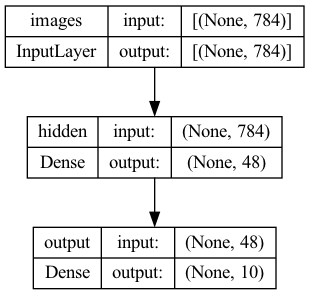

In [4]:
# this requires a couple of installs:
# brew install graphviz 
# sudo apt install graphviz
# or whatever is your OS package manager...
#
# pip install dot
# ^--- in your environment
#

plot_model(our_first_model, to_file='our_first_model.png', show_shapes=True, show_layer_names=True)


Notice that `our_first_model.summary()` printed out the summary of the ANN architecture including the number of trainable parameters.  

## Training the Model
Before training, we `compile` which associates a loss function and an optimizer with our model.  We use `SparseCategoricalCrossentropy` loss, which is just MCE when the labels are in integer format -- i.e., for an image for class 8, the label is `8` and `SparseCategoricalCrossentropy` effectively includes the one-hot encoding operation for us.  We also associate a metric of `accuracy` -- this is not used in the training, but we can track it during the training and then produce a learning curve that includes this metric.  

Also, two methods for showing how to set the optimizer are shown.  In the first, we set the learning rate explicitly.  This interface is shown in the [TF documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/SGD).  The second way just uses the SGD optimizer with default values.  The default learning rate is 0.01.  

In [5]:

opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.01)
our_first_model.compile(optimizer=opt, loss=SparseCategoricalCrossentropy(), metrics=['accuracy']) 
#our_first_model.compile(optimizer='sgd', loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])   ## use defaults for SGD optimizer
results = our_first_model.fit(train_images,  train_labels, batch_size=32, epochs=40, validation_split=0.2)


Epoch 1/40


2023-03-27 21:01:19.747066: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1500/1500 [==============================] - 1s 672us/step - loss: 0.9479 - accuracy: 0.7348 - val_loss: 0.7362 - val_accuracy: 0.7867
Epoch 2/40
1500/1500 [==============================] - 1s 584us/step - loss: 0.6729 - accuracy: 0.8145 - val_loss: 0.6557 - val_accuracy: 0.8110
Epoch 3/40
1500/1500 [==============================] - 1s 579us/step - loss: 0.6232 - accuracy: 0.8292 - val_loss: 0.6162 - val_accuracy: 0.8263
Epoch 4/40
1500/1500 [==============================] - 1s 583us/step - loss: 0.5969 - accuracy: 0.8362 - val_loss: 0.5845 - val_accuracy: 0.8392
Epoch 5/40
1500/1500 [==============================] - 1s 596us/step - loss: 0.5795 - accuracy: 0.8412 - val_loss: 0.5722 - val_accuracy: 0.8430
Epoch 6/40
1500/1500 [==============================] - 1s 705us/step - loss: 0.5647 - accuracy: 0.8475 - val_loss: 0.5686 - val_accuracy: 0.8437
Epoch 7/40
1500/1500 [==============================] - 1s 611us/step - loss: 0.5540 - accuracy: 0.8496 - val_loss: 0.5639 - val_accura

## Visualizing the Training (Learning Curves)

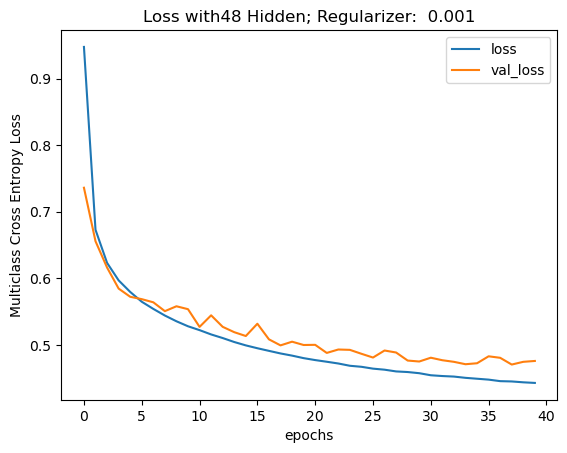

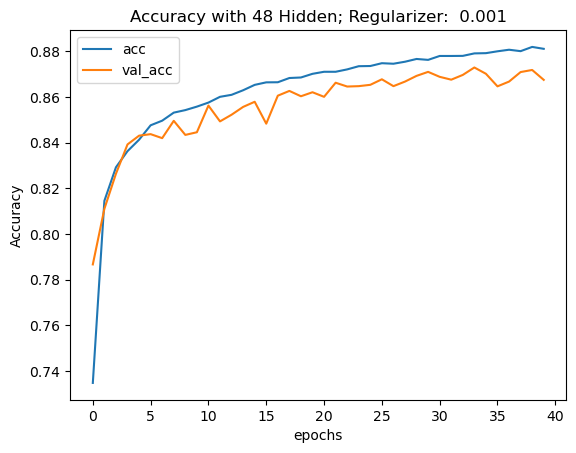

In [6]:
# plot our learning curves
# results.history is a dictionary
loss = results.history['loss']
val_loss = results.history['val_loss']
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

epochs = np.arange(len(loss))

plt.figure()
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.xlabel('epochs')
plt.ylabel('Multiclass Cross Entropy Loss')
plt.title(f'Loss with{hidden_nodes} Hidden; Regularizer: {reg_val : 3.2g}')
plt.legend()
# plt.savefig(f'learning_loss_R_{reg_val}_D_{dropout_rate}_H_{hidden_nodes}.png', dpi=256)


plt.figure()
plt.plot(epochs, acc, label='acc')
plt.plot(epochs, val_acc, label='val_acc')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title(f'Accuracy with {hidden_nodes} Hidden; Regularizer: {reg_val : 3.2g}')
plt.legend()
# plt.savefig(f'learning_acc_R_{reg_val}_D_{dropout_rate}_H_{hidden_nodes}.png', dpi=256)

## Evaluating on the Test Data

First, let's evaluate our model on the test dataset.  Then, let's  produce a confusion matrix and also do some random sampling to see what our errors may look like.  For this visualization, we need some additional libraries.

In [7]:
test_loss, test_acc = our_first_model.evaluate(test_images,  test_labels, verbose=2)
print(f'Test Loss: {test_loss : 3.2f}')
print(f'Test Accuracy: {100 * test_acc : 3.2f}%')

313/313 - 0s - loss: 0.4998 - accuracy: 0.8579 - 214ms/epoch - 682us/step
Test Loss:  0.50
Test Accuracy:  85.79%


In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import seaborn as sns

313/313 [==============================] - 0s 399us/step


[Text(0, 0.5, 'top'),
 Text(0, 1.5, 'trouser'),
 Text(0, 2.5, 'pullover'),
 Text(0, 3.5, 'dress'),
 Text(0, 4.5, 'coat'),
 Text(0, 5.5, 'sandal'),
 Text(0, 6.5, 'shirt'),
 Text(0, 7.5, 'sneaker'),
 Text(0, 8.5, 'bag'),
 Text(0, 9.5, 'ankle boot')]

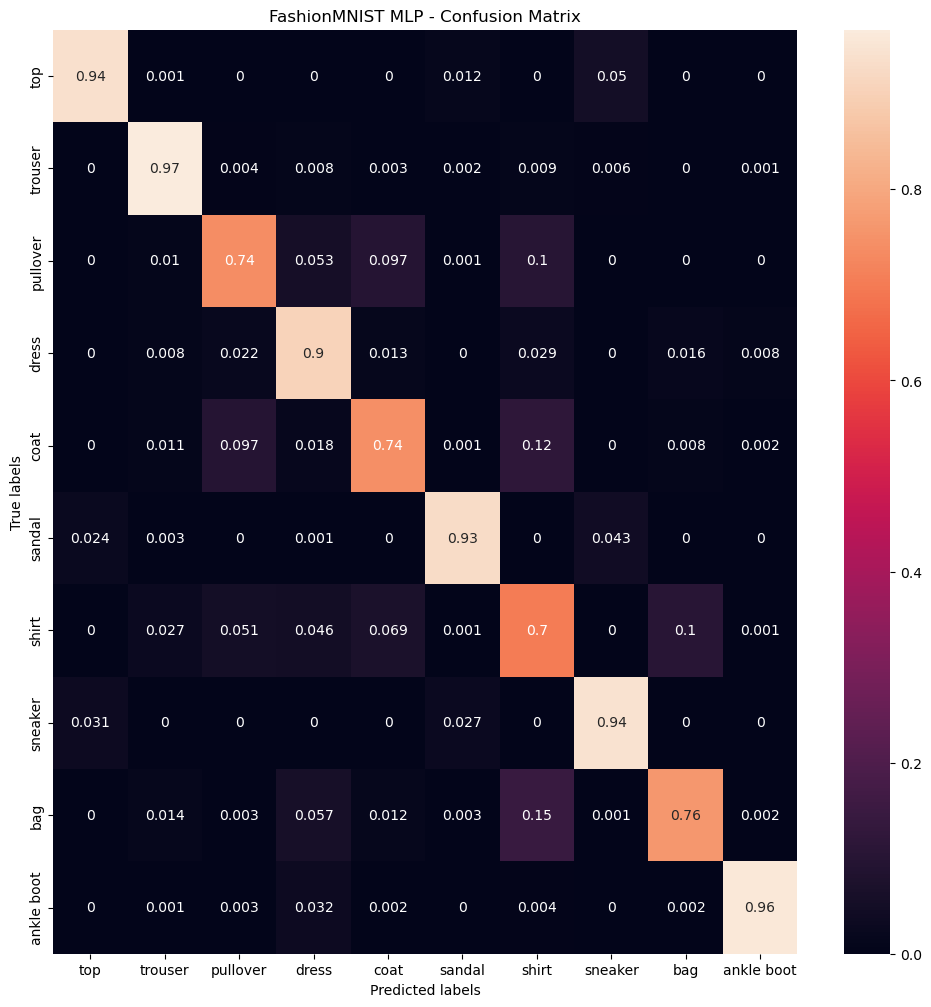

In [10]:
classes = np.asarray(label_names)
preds = our_first_model.predict(test_images)

testY_classes = classes[test_labels]
testY_decision = classes[preds.argmax(axis=1)]

cm = confusion_matrix(testY_classes, testY_decision, normalize='true')
plt.figure(figsize=(12,12))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title(f'{tag_name} MLP - Confusion Matrix') 
ax.xaxis.set_ticklabels(label_names); ax.yaxis.set_ticklabels(label_names)

Let's look at one input and check the SoftMax output

In [11]:
# perform inference on a single image:
prediction = our_first_model.predict(test_images[0].reshape(1,num_pixels))
num_classes = 10
prediction = prediction.reshape(10)
class_decision = np.argmax(prediction)
for m in range(num_classes):
	if m == class_decision:
		print(f'class{m}:\tclass soft-decisions:{prediction[m] : 3.4f}\t(hard decision)')
	else:
		print(f'class{m}:\tclass soft-decisions:{prediction[m] : 3.4f}')



1/1 [==============================] - 0s 9ms/step
class0:	class soft-decisions: 0.0000
class1:	class soft-decisions: 0.0000
class2:	class soft-decisions: 0.0001
class3:	class soft-decisions: 0.0002
class4:	class soft-decisions: 0.0001
class5:	class soft-decisions: 0.0997
class6:	class soft-decisions: 0.0004
class7:	class soft-decisions: 0.1430
class8:	class soft-decisions: 0.0092
class9:	class soft-decisions: 0.7473	(hard decision)


Finally, let's do some random sampling on the test set and check the label and prediction.  We have a routine for this from the previous notebook.

In [12]:
from utils.previous_notebooks import create_montage

hard_predictions = np.argmax(preds, axis=1)

display_images = (test_images * 255).reshape((10000, 28, 28))
create_montage(display_images, hard_predictions, label_names, f'img/{tag_name}_test.png', true_labels=test_labels, N=6)
